In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import h5py

In [ ]:


from src.utils.logger import Logging
from src.data.cavity_dataset import CavityDatasetFromFile
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.nn.ClassicalSolver import ClassicalSolver
from src.poisson import cavity_train
from src.utils.cavity_plot_contour import draw_contourf_regular_2D
from src.utils.error_metrics import lp_error

In [15]:
mode = "hybrid"
num_qubits = 5
output_dim = 3
input_dim = 3
hidden_dim = 50
num_quantum_layers = 1
classic_network = (
    [input_dim, hidden_dim, num_qubits]
    if mode != "classical"
    else [input_dim, hidden_dim, output_dim]
)
DEVICE = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = {
    "batch_size": 64,
    "epochs": 20000,
    "lr": 0.0001,
    "seed": 1,
    "print_every": 100,
    "log_path": "../../checkpoints/cavity",
    "input_dim": input_dim,
    "output_dim": output_dim,
    "num_qubits": num_qubits,
    "hidden_dim": hidden_dim,
    "num_quantum_layers": num_quantum_layers,
    "classic_network": classic_network,
    "q_ansatz": "layered_circuit",  # options: "alternating_layer_tdcnot", "abbas" , farhi , sim_circ_13_half, sim_circ_13 , sim_circ_14_half, sim_circ_14 , sim_circ_15 ,sim_circ_19
    "mode": mode,
    "activation": "tanh",  # options: "null", "partial_measurement_half" , partial_measurement_x
    "shots": None,  # Analytical gradients enabled
    "feature_map": "AngleEmbedding",  # z_feature_map , pauli_feature_map ,custom , Specify the feature map here
    "problem": "cavity",
    "solver": "DV",
    "device": DEVICE,
    "method": "None",
    "cutoff_dim": 2,
}

In [5]:
data_file = "./data/cavity.mat"

obj = CavityDatasetFromFile(data_file, DEVICE)
train_dataloader = obj.__getitem__()

domain.shape=(10100, 6), left.shape=(1515, 6), bottom.shape=(1515, 6), up.shape=(1515, 6), right.shape=(1515, 6), initial.shape=(1500, 6), sensors.shape=(5050, 6)


In [6]:
log_path = args["log_path"]
logger = Logging(log_path)

In [16]:
if args["solver"] == "CV":
    model = CVPDESolver(args, logger, train_dataloader, DEVICE)
else:
    model = DVPDESolver(args, logger, train_dataloader, DEVICE)


# Training loop
logger.print(f"The settings used: {args}")
for key, value in args.items():
    logger.print(f"{key} : {value}")


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 100, 'log_path': '../../checkpoints/cavity', 'input_dim': 3, 'output_dim': 3, 'num_qubits': 5, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [3, 50, 5], 'q_ansatz': 'layered_circuit', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'feature_map': 'AngleEmbedding', 'problem': 'cavity', 'solver': 'DV', 'device': 'cpu', 'method': 'None', 'cutoff_dim': 2}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 100
INFO:src.utils.logger:log_path : ../../checkpoints/cavity
INFO:src.utils.logger:input_dim : 3
INFO:src.utils.logger:output_dim : 3
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [3, 50, 5]
INFO:src.utils.logger:q_

Total number of parameters: 1035


In [ ]:
# print(model)

cavity_train.train(model)


INFO:src.utils.logger:The circuit used in the study:


The circuit is saved in ../../checkpoints/cavity/2025-02-12_12-30-43-247096


INFO:src.utils.logger:Iteration: 0, loss_r = 1.6e-03 ,  loss_bc = 1.1e+00,  lr = 5.0e-03, time_taken = 1.5e+01
INFO:src.utils.logger:Model state saved to ../../checkpoints/cavity/2025-02-12_12-30-43-247096/model.pth


# Testing


In [ ]:
skip = 10
tstep = 101
xstep = 100
ystep = 100

TEST_DATA_PKL = "./data/cavity.mat"  # Assuming this is the correct path
data = h5py.File(TEST_DATA_PKL, "r")  # load dataset from matlab

domain = pd.DataFrame(data["cavity_internal"]).T.to_numpy()

#  t = tf.reshape(tstep,N_data)[:,0].T
time_ = (
    domain[:, 0:1].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
)  # (101, 10, 10)
xfa = domain[:, 1:2].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
yfa = domain[:, 2:3].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
ufa = domain[:, 3:4].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
vfa = domain[:, 4:5].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)
pfa = domain[:, 5:6].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].reshape(-1, 1)

new_shape = domain[:, 0:1].reshape(tstep, xstep, ystep)[:, ::skip, ::skip].shape

In [ ]:
test_torch_data = torch.tensor(
    np.concatenate([time_, xfa, yfa], axis=1), dtype=torch.float32
).to(model.device)
with torch.no_grad():
    predictions = model.forward(test_torch_data)
if predictions.is_cuda:
    predictions = predictions.cpu()
u_pred = predictions[:, 0:1].numpy()
v_pred = predictions[:, 1:2].numpy()
p_pred = predictions[:, 2:3].numpy()

In [ ]:
text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred, ufa, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred, vfa, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred, pfa, (text + "P%"), logger, 2)

logger.print("Final loss %e" % (model.loss_history[-1]))

logger.print("******************************\n")

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:RelL2_U%  : 1.702e+02 
INFO:src.utils.logger:RelL2_V%  : 9.885e+01 
INFO:src.utils.logger:RelL2_P%  : 8.635e+01 
INFO:src.utils.logger:Final loss 8.653104e-01
INFO:src.utils.logger:******************************

INFO:src.utils.logger:file directory:
INFO:src.utils.logger:../../checkpoints/cavity/2025-02-09_03-41-39-831573


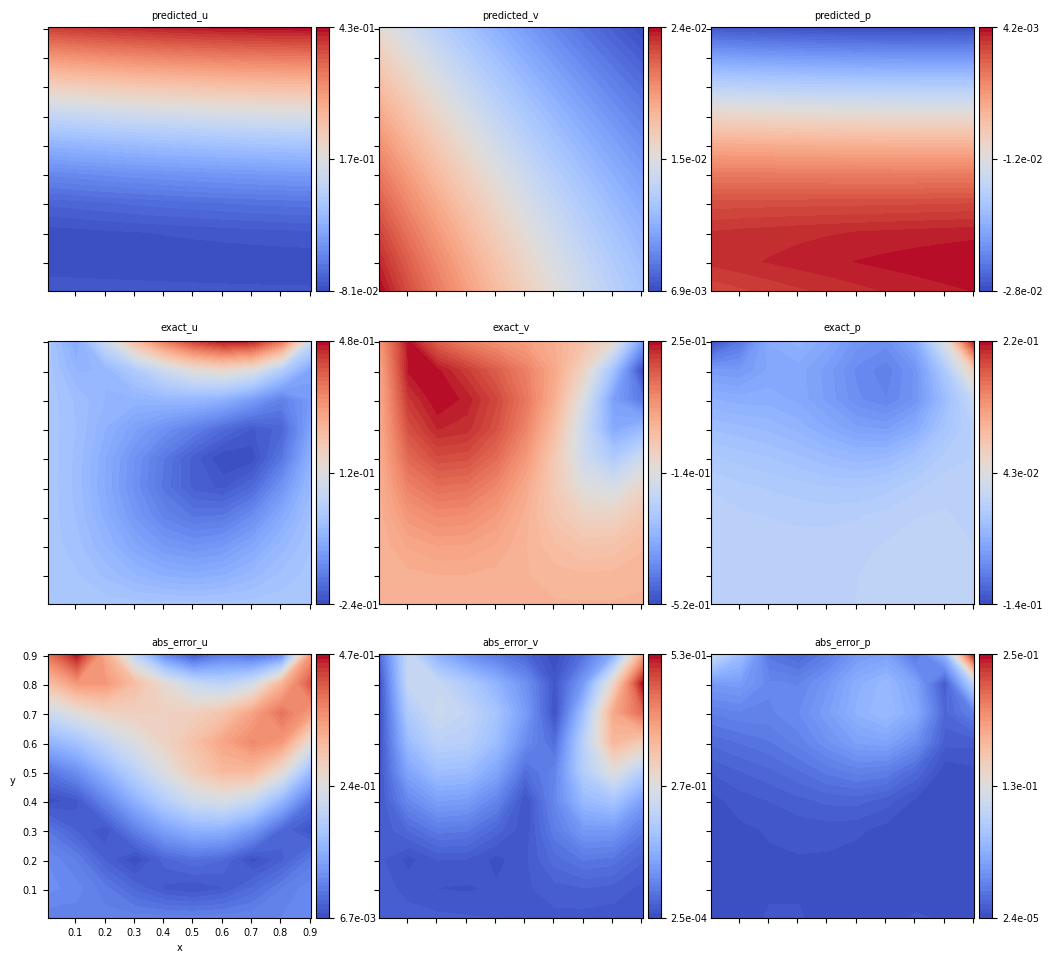

In [ ]:
tstep = new_shape[0]
xstep = new_shape[1]
ystep = new_shape[2]

txy = [xfa, yfa, time_]
steps = [tstep, xstep, ystep]

#  t = tf.reshape(tstep,N_data)[:,0].T
tf = time_.reshape(tstep, xstep, ystep)
xf = xfa.reshape(tstep, xstep, ystep)
yf = yfa.reshape(tstep, xstep, ystep)


exact_u = ufa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_v = vfa.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_p = pfa.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]

u_pred_tanh = u_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
v_pred_tanh = v_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
p_pred_tanh = p_pred.reshape(tstep, xstep, ystep)  # [1,:].reshape(100,100)[0,:]


tanh_error_u = np.abs(u_pred_tanh - exact_u)
tanh_error_v = np.abs(v_pred_tanh - exact_v)
tanh_error_p = np.abs(p_pred_tanh - exact_p)

data = [
    u_pred_tanh,
    v_pred_tanh,
    p_pred_tanh,
    exact_u,
    exact_v,
    exact_p,
    tanh_error_u,
    tanh_error_v,
    tanh_error_p,
]

titles = [
    "predicted_u",
    "predicted_v",
    "predicted_p",
    "exact_u",
    "exact_v",
    "exact_p",
    "abs_error_u",
    "abs_error_v",
    "abs_error_p",
]

plot_xy = False

time_steps = [0, 99]
xy_labels = [r"$x→$", r"$y→$"]

x = xf[0, :, :][..., None]
y = yf[0, :, :][..., None]
nrows_ncols = (3, 3)
values = [99]
xref = 1
yref = 1
model_dirname = model.log_path
img_width = 10
img_height = 10
ticks = 3
fontsize = 7
labelsize = 7
axes_pad = 0.5
X = np.concatenate([x, y], axis=-1)
# for time_step in time_steps:
#     for index, (title, z) in enumerate(zip(titles, data)):
#         file_name = os.path.join(model.log_path, f"{index}_{title}_time{time_step}.png")
#         plot_xy = index == 12
#         fig = plot_contour(X, z[time_step, :, :], file_name, plot_xy, xy_labels)

draw_contourf_regular_2D(
    tf[:, 0, 0],
    xf[0, 0, :],
    yf[0, :, 0],
    data,
    titles,
    nrows_ncols,
    values,
    xref,
    yref,
    model_dirname,
    img_width,
    img_height,
    ticks,
    fontsize,
    labelsize,
    axes_pad,
)

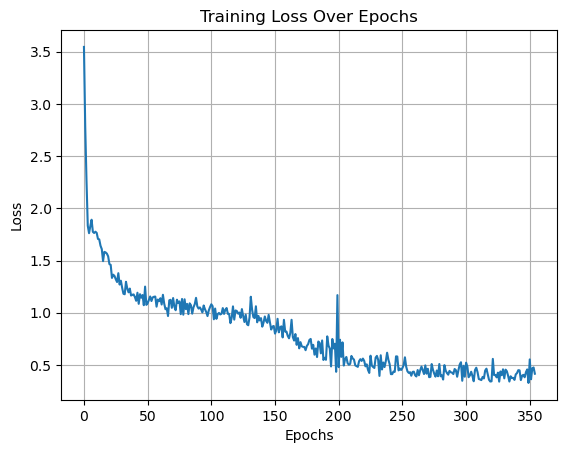

In [ ]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)